# convert_IMERG_HDF5_to_csv

**Project:** Texas and Georgia Agriculture

**Date:** March 04, 2025

**Code Contact:** Kelechi Igwe, [igwekelechi.e@gmail.com]

**Inputs:** 
    - Folder path to where all HDF5 files are stored
    - (i.e. Study Area Shapefiles for:
        the world (ne_110m_coastline.shp), 
        for Georgia (georgia_NASS_districts.shp) and 
        for Texas (texas_NASS_districts.shp)
        
**Outputs:** A CSV file containing Precipitation data for each polygon in the shapefile over the number of years specified

**Description:** 

This script will read and extract precipitation data from IMERG HDF5 format to CSV using python. 

Reference: Modified from NASA IMERG Tutorials page: https://gpm.nasa.gov/data/tutorials

In [26]:
# Import all required libraries

import numpy as np
import h5py # to read HDF5 files
import geopandas as gpd # To read shapefiles
import rasterio
import glob
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import box
import matplotlib.pyplot as plt
import shapefile as shp
import os
import calendar

In [27]:
# Import shapefile of continents
url_shp = r'C:\Users\kelechi\OneDrive - Kansas State University\Desktop\Research Resources\Conferences\NASA_DEVELOP\Data\ne_110m_coastline'
url_shp2 = os.path.join(url_shp, 'ne_110m_coastline.shp')
shapeID = shp.Reader(url_shp2)

# Import study area shapefiles
georgia = gpd.read_file(r"C:\Users\kelechi\OneDrive - Kansas State University\Desktop\Research Resources\Conferences\NASA_DEVELOP\Data\NASS_Districts_Shapefiles\georgia_NASS_districts.shp")
texas = gpd.read_file(r"C:\Users\kelechi\OneDrive - Kansas State University\Desktop\Research Resources\Conferences\NASA_DEVELOP\Data\NASS_Districts_Shapefiles\texas_NASS_districts.shp")

# If the file path you pasted includes backslashes "\" rather than forward slashes "/", include "r" before your file path. E.g. folder_path = r"C:\.."
hdf_folder_path = r"C:\Users\kelechi\OneDrive - Kansas State University\Desktop\Research Resources\Conferences\NASA_DEVELOP\Data\GPM_3IMERGM_07-20250217_203754"

hdf_files = glob.glob(hdf_folder_path + '/*.HDF5')
#hdf_files


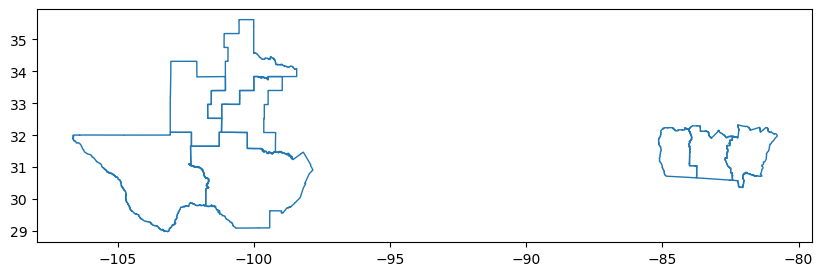

In [29]:
# Plot study area maps
fig, ax = plt.subplots(figsize=(10, 6))

# Plot texas and georgia shapefiles
texas.boundary.plot(ax=ax, linewidth=1)
georgia.boundary.plot(ax=ax, linewidth=1)

plt.show()

## Read and Visualize a single HDF5 file

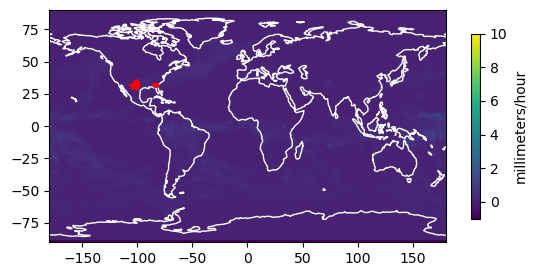

In [30]:

'''
This entire cell is modified from NASA tutorials page: https://gpm.nasa.gov/data/tutorials
'''

# Test code on a single HDF5 file
single_file=hdf_files[0]
data = h5py.File(single_file,'r')


# -- extract the 3600x1800 element precipitation array.
# For Version 6 IMERG HDF5 files, read the "precipitationCal"
# variable if it is a half-hour file and the "precipitation"
# variable if it is a monthly file.  For Version 7, the variable
# is "precipitation" for both durations.

precip = data['/Grid/precipitation'][:]

# -- get rid of the dummy single-element first dimension,
# transpose to get longitude on the x axis, and flip vertically
# so that latitude is displayed south to north as it should be
precip = np.flip( precip[0,:,:].transpose(), axis=0 )

# -- display the precipitation data. Regions with missing data
# values have negative values in the precip variable so allow
# the color table to extend to negative values.
plt.imshow( precip, vmin=-1, vmax=10, extent=[-180,180,-90,90] )

# -- add a color bar
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('millimeters/hour')

# -- display the optional coastline shapefile
for shape in shapeID.shapeRecords():
  point = np.array( shape.shape.points )
  dummy = plt.plot( point[:,0] , point[:,1], color="white",
    linewidth=1 )

# Overlay the Texas and Georgia shapefiles on the plot
texas.boundary.plot(ax=plt.gca(), color='red', linewidth=1.5, label="Texas Boundaries")
georgia.boundary.plot(ax=plt.gca(), color='red', linewidth=1.5, label="Texas Boundaries")


# -- save the image to disk and display on the screen
#plt.savefig('imerg.png',dpi=200)
plt.show()

# -- end of Python script


## Extract Precipitation from all HDF5 files

In [41]:

'''
This part loops through all the HDF5 files and extracts data for the study area
'''

all_months_list = []

for file in hdf_files[-1:]:
    filename = str(os.path.basename(file).split(".")[-4]).split("-")[0]
    year = int(filename[:4]) # change to integers
    month = int(filename[4:-2]) # change to integers
    days_in_month = calendar.monthrange(year, month) # Get number of days for the current month and year
    hours_in_month = days_in_month[1] * 24 # Get number of hours for the current month and year
    print("Processing: ", filename)

    
    '''
    The part of the code enclosed with '#####' below is from NASA tutorials page: https://gpm.nasa.gov/data/tutorials
    '''
    ###########################
    data = h5py.File(file,'r')
    
    # -- extract the 3600x1800 element precipitation array.
    # For Version 6 IMERG HDF5 files, read the "precipitationCal"
    # variable if it is a half-hour file and the "precipitation"
    # variable if it is a monthly file.  For Version 7, the variable
    # is "precipitation" for both durations.
    
    precip = data['/Grid/precipitation'][:]

    # -- get rid of the dummy single-element first dimension,
    # transpose to get longitude on the x axis, and flip vertically
    # so that latitude is displayed south to north as it should be
    precip = np.flip( precip[0,:,:].transpose(), axis=0 )


    # Define the global extent of the dataset (IMERG standard grid)
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 90
    rows, cols = precip.shape # Use this to create raster image
    
    dx = (lon_max - lon_min) / cols
    dy = (lat_max - lat_min) / rows
    ################################
    
    # Create transform
    transform = rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, cols, rows)

    # Create a list to store results for each district
    results = []
    # Loop through each district (polygon) within the shapefile
    for i, row in georgia.iterrows(): # Texas shapefile
        xmin, ymin, xmax, ymax = row.geometry.bounds
        geom = [box(xmin, ymin, xmax, ymax)]
    
        # Convert the HDF file to raster
        # Clip raster to bounding box
        with rasterio.open(
            "temp.tif", "w", driver="GTiff", height=rows, width=cols, count=1,
            dtype=precip.dtype, crs="EPSG:4326", transform=transform
        ) as temp_raster:
            temp_raster.write(precip, 1)
    
        # Read the TIFF file and summarize. Do we take the mean or the sum?
        with rasterio.open("temp.tif") as new_raster:
    
            # Clip the raster to the district's boundary
            clipped_image, out_transform = mask(new_raster, geom, crop=True)

            # Flatten the array to a 1D list and remove missing values (NaNs)
            valid_data = clipped_image.flatten()
            
            # Check if there are any valid values (i.e., not all are NaN)
            if np.isnan(valid_data).all():
                mean_precip = np.nan  # No valid precipitation data
            else:
                mean_precip = np.nanmean(valid_data)  # Compute mean, ignoring NaNs
        
    
        # Save result for each district in a list
        results.append({"NASS_district": row["NASS"], 
                        "Year":year, 
                        "month": month, 
                        "Precip (mm/hr)": mean_precip,
                        "hours_in_month": hours_in_month,
                        "Monthly Precip (mm)": mean_precip * hours_in_month
                       })
    
    # Convert list to DataFrame
    precip_df = pd.DataFrame(results)
    all_months_list.append(precip_df)
    

# Show first couple of rows
print('Script run is successful. See latest year data below: \n', precip_df.head())


Processing:  20241001
Script run is successful. See latest year data below: 
    NASS_district  Year  month  Precip (mm/hr)  hours_in_month  \
0             70  2024     10        0.007667             744   
1             80  2024     10        0.024134             744   
2             90  2024     10        0.067823             744   

   Monthly Precip (mm)  
0             5.704000  
1            17.955687  
2            50.460412  


In [42]:
# Write dataframe to CSV
df_all_months = pd.concat(all_months_list, axis = 0, ignore_index=True)

# Drop columns not needed
df_all_months = df_all_months.drop(columns=['Precip (mm/hr)', 'hours_in_month'])

# Save dataframe to CSV format (Note: this will save to same folder where script is located)
df_all_months.to_csv("IMERG_precip_georgia_oct.csv", index=False)

# Print the dataframe
df_all_months

,NASS_district,Year,month,Monthly Precip (mm)
0,70,2024,10,5.704000
1,80,2024,10,17.955687
2,90,2024,10,50.460412


C:\Users\kelechi\AppData\Local\Temp\ipykernel_17068\4280670266.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sc = ax.scatter(texas.centroid.x, texas.centroid.y, c=precip_df["Monthly Precip (mm)"], cmap='Greens', edgecolors='k', s=100)


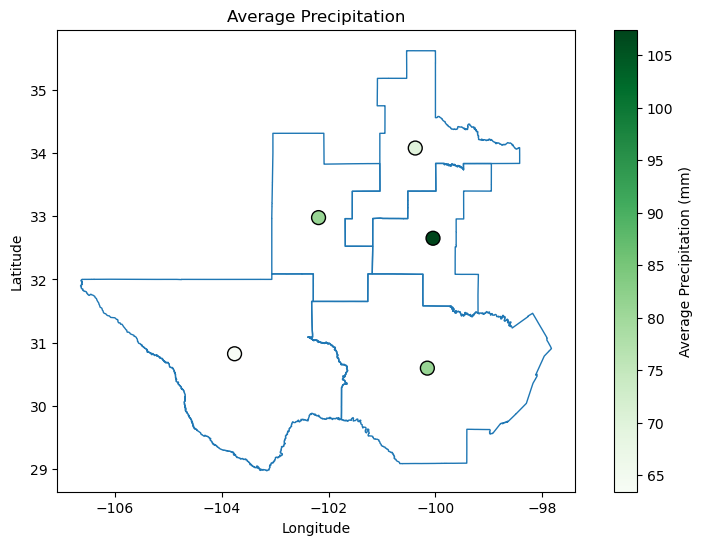

In [42]:
## Show how results look for a single file
# Plot the clipped precipitation data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot texas shapefile
texas.boundary.plot(ax=ax, linewidth=1)

# Plot precipitation data
sc = ax.scatter(texas.centroid.x, texas.centroid.y, c=precip_df["Monthly Precip (mm)"], cmap='Greens', edgecolors='k', s=100)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Average Precipitation (mm)")
plt.title("Average Precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()